In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt

# importing Qiskit
from qiskit import *
#from qiskit.aqua.algorithms import Grover
#from qiskit.aqua.components.oracles import TruthTableOracle
from qiskit import QuantumCircuit
from qiskit.algorithms import AmplificationProblem
from qiskit.quantum_info import Statevector
from qiskit.algorithms import Grover
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor

### Keresés random adatbázisban klasszikusan

In [24]:

def oracle1(input):
    value = 6
    if input == value:
        return True
    else: return False

l = []
for i in range(1000):    

    randlist = random.sample(range(0,10), 10)

    #print(randlist)

    for index, value in enumerate(randlist):
        if oracle1(value) == True:
            #print("pozíció: ", index)
            #print("futtatások száma:", index+1)
            l.append(index+1)
            break
print("Átlagos futási szám:", np.mean(l))

    

Átlagos futási szám: 5.614


### Kvantumosan, Grover algoritmussal

In [25]:
#prepare the oracle as a controlled z gate
oracle = QuantumCircuit(2, name = 'oracle')
oracle.cz(0,1)
oracle.to_gate()
oracle.draw()



q_0: ─■─
      │ 
q_1: ─■─

In [26]:

backend = Aer.get_backend('statevector_simulator')
grover_circ = QuantumCircuit(2,2) #2 qbits, 2 classical registers
grover_circ.h([0,1]) #perpare superpos state with hadamard gate
grover_circ.append(oracle, [0,1])
grover_circ.draw()


┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│  oracle │
q_1: ┤ H ├┤1        ├
     └───┘└─────────┘
c_0: ════════════════
                     
c_1: ════════════════

In [27]:
job = execute(grover_circ, backend) #simulate
result = job.result()

sv = result.get_statevector()
np.around(sv,2)

array([ 0.5+0.j,  0.5+0.j,  0.5+0.j, -0.5+0.j])

In [28]:
reflection = QuantumCircuit(2, name = 'reflection')
reflection.h([0,1])
reflection.z([0,1])
reflection.cz(0,1)
reflection.h([0,1])
reflection.to_gate()
reflection.draw()

┌───┐┌───┐   ┌───┐
q_0: ┤ H ├┤ Z ├─■─┤ H ├
     ├───┤├───┤ │ ├───┤
q_1: ┤ H ├┤ Z ├─■─┤ H ├
     └───┘└───┘   └───┘

In [29]:
backend = Aer.get_backend('qasm_simulator')
grover_circ = QuantumCircuit(2,2)
grover_circ.h([0,1])
grover_circ.append(oracle, [0,1])
grover_circ.append(reflection, [0,1])
grover_circ.measure([0,1],[0,1])

grover_circ.draw()

┌───┐┌─────────┐┌─────────────┐┌─┐   
q_0: ┤ H ├┤0        ├┤0            ├┤M├───
     ├───┤│  oracle ││  reflection │└╥┘┌─┐
q_1: ┤ H ├┤1        ├┤1            ├─╫─┤M├
     └───┘└─────────┘└─────────────┘ ║ └╥┘
c_0: ════════════════════════════════╩══╬═
                                        ║ 
c_1: ═══════════════════════════════════╩═

Job Status: job has successfully run


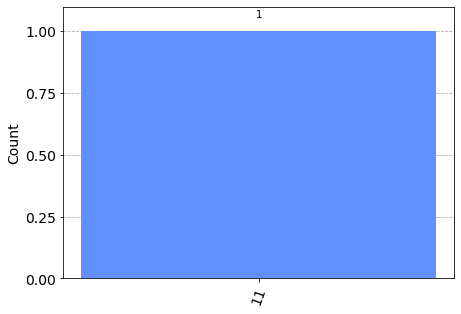

In [30]:
transpiled_grover_circuit = transpile(grover_circ, backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

job = execute(grover_circ, backend, shots = 1)
result = job.result()
result.get_counts()

results = job.result()
answer = results.get_counts(grover_circ)
plot_histogram(answer)


[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j]


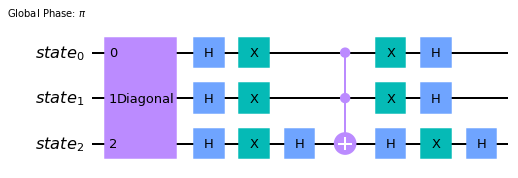

In [167]:
sample = '0110'

good_state = ['110','101']
oracle = Statevector([0,0,0,0,0,1,1,0])

#oracle = Statevector.from_label(sample) #creates staevector from winner sample

print(np.around(oracle,2))
problem = AmplificationProblem(oracle, is_good_state=good_state) #

grover_circuits = []
for iteration in range(0,20): #experimental test for multiple layers
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem) #this constructs the grover circ from the amplification problem, given a sample
    circuit.measure_all()
    grover_circuits.append(circuit)

grover_circuits[10].draw()
problem.grover_operator.decompose().draw(output='mpl')

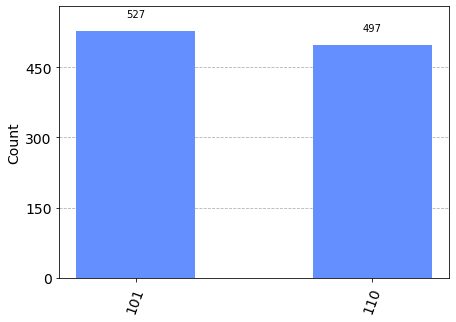

In [177]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(grover_circuits[1], aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

Job Status: job has successfully run
[75, 483, 941, 989, 602, 116, 20, 373, 837, 1017, 698, 219, 2, 284, 804, 1024, 834, 288, 6, 180]


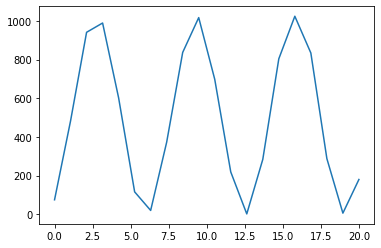

In [43]:
#this job monitor is more tunable
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuits[1], backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)
answers = []

for i in range(0,20):
    job = execute(grover_circuits[i], backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(grover_circuits[i])
    answers.append(answer[sample])

plot_histogram(answer)
print(answers)
iters = np.linspace(0,20,20)
plt.plot(iters, answers)
    

Optima number of iterations. As expected, periodic, with a period of: 

In [ ]:
problem = AmplificationProblem(oracle, is_good_state=sample)
grover = Grover(iterations=100, sample_from_iterations=True)

In [ ]:
iterations = Grover.optimal_num_iterations(num_solutions=1, num_qubits=4)
iterations

3

Grover with multiple good states

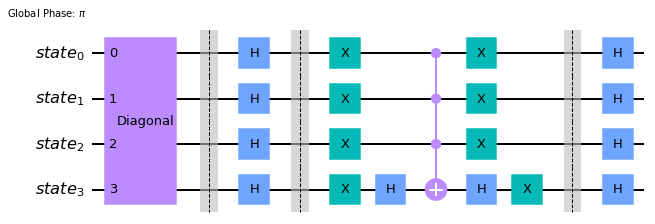

In [ ]:
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.decompose().draw(output='mpl')

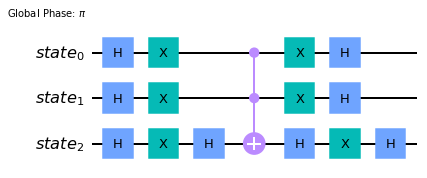

In [146]:

oracle = QuantumCircuit(3)
oracle.cz(0, 1)
oracle.cz(1,2)
good_state = '110'
problem = AmplificationProblem(oracle, is_good_state=good_state)

grover_circs = []
for iteration in range(0,20): #experimental test for multiple iterations
    grover = Grover(iterations=iteration)
    circuit = grover.construct_circuit(problem) #this constructs the grover circ from the amplification problem, given a sample
    circuit.measure_all()
    grover_circs.append(circuit)

grover_circs[1].draw()
problem.grover_operator.decompose().draw(output='mpl')

In [147]:
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circs[1], backend, optimization_level=3)
job = backend.run(transpiled_grover_circuit)
job_monitor(job, interval=2)
answers = []

for i in range(0,20):
    job = execute(grover_circs[i], backend, shots = 1024)
    result = job.result()
    result.get_counts()
    results = job.result()
    answer = results.get_counts(grover_circs[i])
  




Job Status: job has successfully run


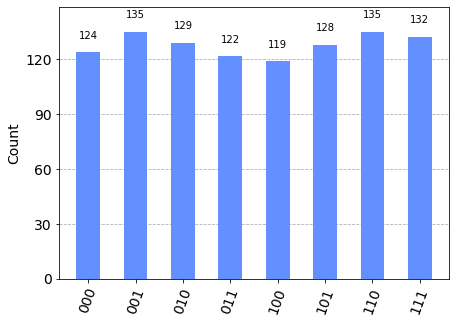

In [156]:
transpiled_qc = transpile(grover_circs[3], aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())

stackoverflow megoldás

In [111]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.classicalfunction import classical_function
from qiskit.circuit.classicalfunction.types import Int1
#from qiskit.circuit.classicalfunction import Int1

# define a classical function that can be turned into a circuit
@classical_function
def oracle(x1: Int1, x2: Int1, x3: Int1) -> Int1:
    return (x1 and x2 and x3) or (not x1 and x2 and not x3)

bitcircuit = oracle.synth()  # turn it into a circuit
bitcircuit.draw()


q_0: ───────■──
            │  
q_1: ──■────■──
       │    │  
q_2: ──o────┼──
     ┌─┴─┐┌─┴─┐
q_3: ┤ X ├┤ X ├
     └───┘└───┘

In [114]:

phaseoracle = QuantumCircuit(4)
phaseoracle.x(3)
phaseoracle.h(3)
phaseoracle.compose(bitcircuit, inplace=True)
phaseoracle.h(3)
phaseoracle.x(3)

backend = Aer.get_backend('statevector_simulator')
grover_circ = QuantumCircuit(4,4) #4 qbits, 4 classical registers
grover_circ.h([0,1,2,3]) #perpare superpos state with hadamard gate
grover_circ.append(oracle, [0,1,2,3])
grover_circ.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤0        ├
     ├───┤│         │
q_1: ┤ H ├┤1        ├
     ├───┤│  Oracle │
q_2: ┤ H ├┤2        ├
     ├───┤│         │
q_3: ┤ H ├┤3        ├
     └───┘└─────────┘
c_0: ════════════════
                     
c_1: ════════════════
                     
c_2: ════════════════
                     
c_3: ════════════════

In [78]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U_s"
    return U_s

In [133]:
backend = Aer.get_backend('qasm_simulator')

n = 3
qr = QuantumRegister(n, 'q')
cr = ClassicalRegister(n, 'c')

quantcirc = QuantumCircuit(qr,cr)

quantcirc.h(qr[0:n])

quantcirc.append(oracle, [0,1,2])
quantcirc.append(diffuser(n), [0,1,2])


quantcirc.measure(qr,cr)

quantcirc.draw()

CircuitError: 'The amount of qubit(3)/clbit(0) arguments does not match the gate expectation (4).'

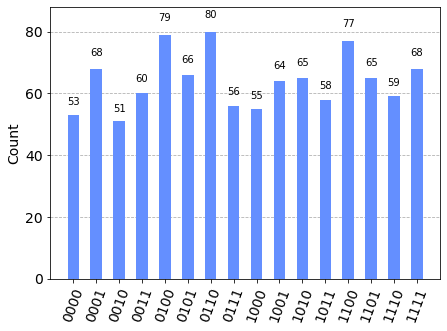

In [132]:
transpiled_qc = transpile(quantcirc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_simulator.run(qobj).result()
plot_histogram(result.get_counts())